In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import imp
import os
from sqlalchemy import create_engine
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
sn.set_context('notebook')

# NOPE calibration dataset

This notebook forms the first part of calibrating and evaluatiing the new [NOPE model](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model.ipynb). The overall aim is to explore different model structures and then use data from the [RID programme](https://github.com/JamesSample/rid) to (i) calibrate the chosen model, and (ii) investigate parameter-related uncertainty.

This notebook first creates a calibration/validation dataset and then explores some basic data characteristics. It also generates NOPE input files for each year from 1990 to 2015.

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')
rid = imp.load_source('useful_rid_code', rid_func_path)

# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

## 1. Calibration and validation datasets

### 1.1. Water chemistry

The first step is to compile a dataset that can be used for model calibration and validation. The RID programme comprises 155 sites, all of which have been monitored at some point since 1990 (although no site has a complete water chemistry record for the entire time period). For loads estimation, we will used the HBV modelled values provided by NVE.

**Note:** There will be considerable errors in the modelled flow data, as well as in the observed load estimates (which are often based on just a few water chemistry samples per year). At this stage, I will not attempt to explicitly model uncertainty in the observed input datasets, but this is clearly an important omission.

The code below loops over all the sites and extracts data where available.

In [3]:
# Read site data
in_xlsx = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Sites_List.xlsx'
rid_df = pd.read_excel(in_xlsx, sheetname='RID_All')

# Pars of interest
# Only TOTN and TOTP for now
par_list = ['TOTP', 'TOTN']

# Names in database are not consistent, so
# need to remap
par_names_list = ['tot-p', 'tot-n']

In [4]:
# Period of interest
st_yr, end_yr = 1990, 2016

# Container for results 
loads_list = []

# Loop over sites
for stn_id in rid_df['station_id'].values:
    # Loop over years
    for year in range(st_yr, end_yr+1):
        print 'Processing Station ID %s for %s' % (stn_id, year)
        
        # Get loads
        l_df = rid.estimate_loads(stn_id, par_list, 
                                  year, engine,
                                  infer_missing=False)
        
        if l_df is not None:
            # Name and reset index
            l_df.index.name = 'station_id'
            l_df.reset_index(inplace=True)

            # Add year
            l_df['year'] = year

            # Add to output
            loads_list.append(l_df)

# Concatenate to new df
lds_ts = pd.concat(loads_list, axis=0)

# Reorder and rename
lds_ts = lds_ts[['station_id', 'year'] + ['%s_tonnes' % i for i in par_list]]
lds_ts.columns = ['station_id', 'year'] + ['%s_tonnes' % i for i in par_names_list]

Processing Station ID 29615 for 1990
Processing Station ID 29615 for 1991
Processing Station ID 29615 for 1992
Processing Station ID 29615 for 1993
Processing Station ID 29615 for 1994
Processing Station ID 29615 for 1995
Processing Station ID 29615 for 1996
Processing Station ID 29615 for 1997
Processing Station ID 29615 for 1998
Processing Station ID 29615 for 1999
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 2000
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 2001
    WARNING
  

In [5]:
lds_ts.head()

,station_id,year,tot-p_tonnes,tot-n_tonnes
0,29615,1990,39.700336,1235.212106
0,29615,1991,33.353097,1105.169503
0,29615,1992,23.337892,1409.367745
0,29615,1993,52.173714,1586.323638
0,29615,1994,33.284365,1724.631323


### 1.2. Flow

In [6]:
# Get flow data
q_df = rid.get_flow_volumes(rid_df, st_yr, end_yr, engine)

q_df.head()

,station_id,year,mean_q_1000m3/day
0,29615,1990,10119.152564
1,29615,1991,7884.893256
2,29615,1992,7838.387948
3,29615,1993,9867.524888
4,29615,1994,10823.288734


### 1.3. Combine

In [7]:
# Join
df = pd.merge(q_df, lds_ts, how='left',
              on=['station_id', 'year'])

df.head()

,station_id,year,mean_q_1000m3/day,tot-p_tonnes,tot-n_tonnes
0,29615,1990,10119.152564,39.700336,1235.212106
1,29615,1991,7884.893256,33.353097,1105.169503
2,29615,1992,7838.387948,23.337892,1409.367745
3,29615,1993,9867.524888,52.173714,1586.323638
4,29615,1994,10823.288734,33.284365,1724.631323


In [8]:
# Save output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_RID_Calibration_Data\rid_all_obs_loads_flows_1990_2016.csv')
df.to_csv(out_csv, index=False)

In [12]:
print 'Years with flow data:         ', len(df)
print 'Years with TOTN data:         ', len(df['tot-n_tonnes'].dropna())
print 'Years with TOTP data:         ', len(df['tot-p_tonnes'].dropna())
print 'Years with flow, N and P data:', len(df.dropna(how='any'))

Years with flow data:          4185
Years with TOTN data:          2552
Years with TOTP data:          1777
Years with flow, N and P data: 1777


## 2. Autocorrelation plots

In most cases there are too many "no data" values to meaningfully estimate autocorrelation for TOTP, but the plots below nevertheless give a reasonable indication of what might be expected. The shaded areas on the ACF plots highlight the region beyond which autocorrelation is significant at p < 0.05. In general, there is little temporal autocorrelation in the parameters of interest between one year and the next.

Plots for all 155 sites are saved to the folder specified below. **The example shown is for the Glomma**.

In [14]:
# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_RID_Calibration_Data\Autocor_Plots')

# Loop over sites
for stn_id in rid_df['station_id'].values:
    # Setup fig
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
    
    # Get data
    df2 = df.query('station_id == @stn_id')
    
    # Set index
    df2.index = df2['year']
    
    # Plot
    for idx, par in enumerate(['mean_q_1000m3/day',] + 
                              ['%s_tonnes' % i for i in par_names_list]):
        df2[par].plot(ax=axes[idx, 0], marker='o')
        plot_acf(df2[par].dropna(), ax=axes[idx, 1])
        axes[idx, 0].set_title('Time series (%s)' % par)
        axes[idx, 1].set_title('ACF (%s)' % par)
        
    # Tidy
    plt.tight_layout()
    
    # Save
    out_path = os.path.join(out_fold, '%s.png' % stn_id)
    plt.savefig(out_path, dpi=200)
    plt.close()    

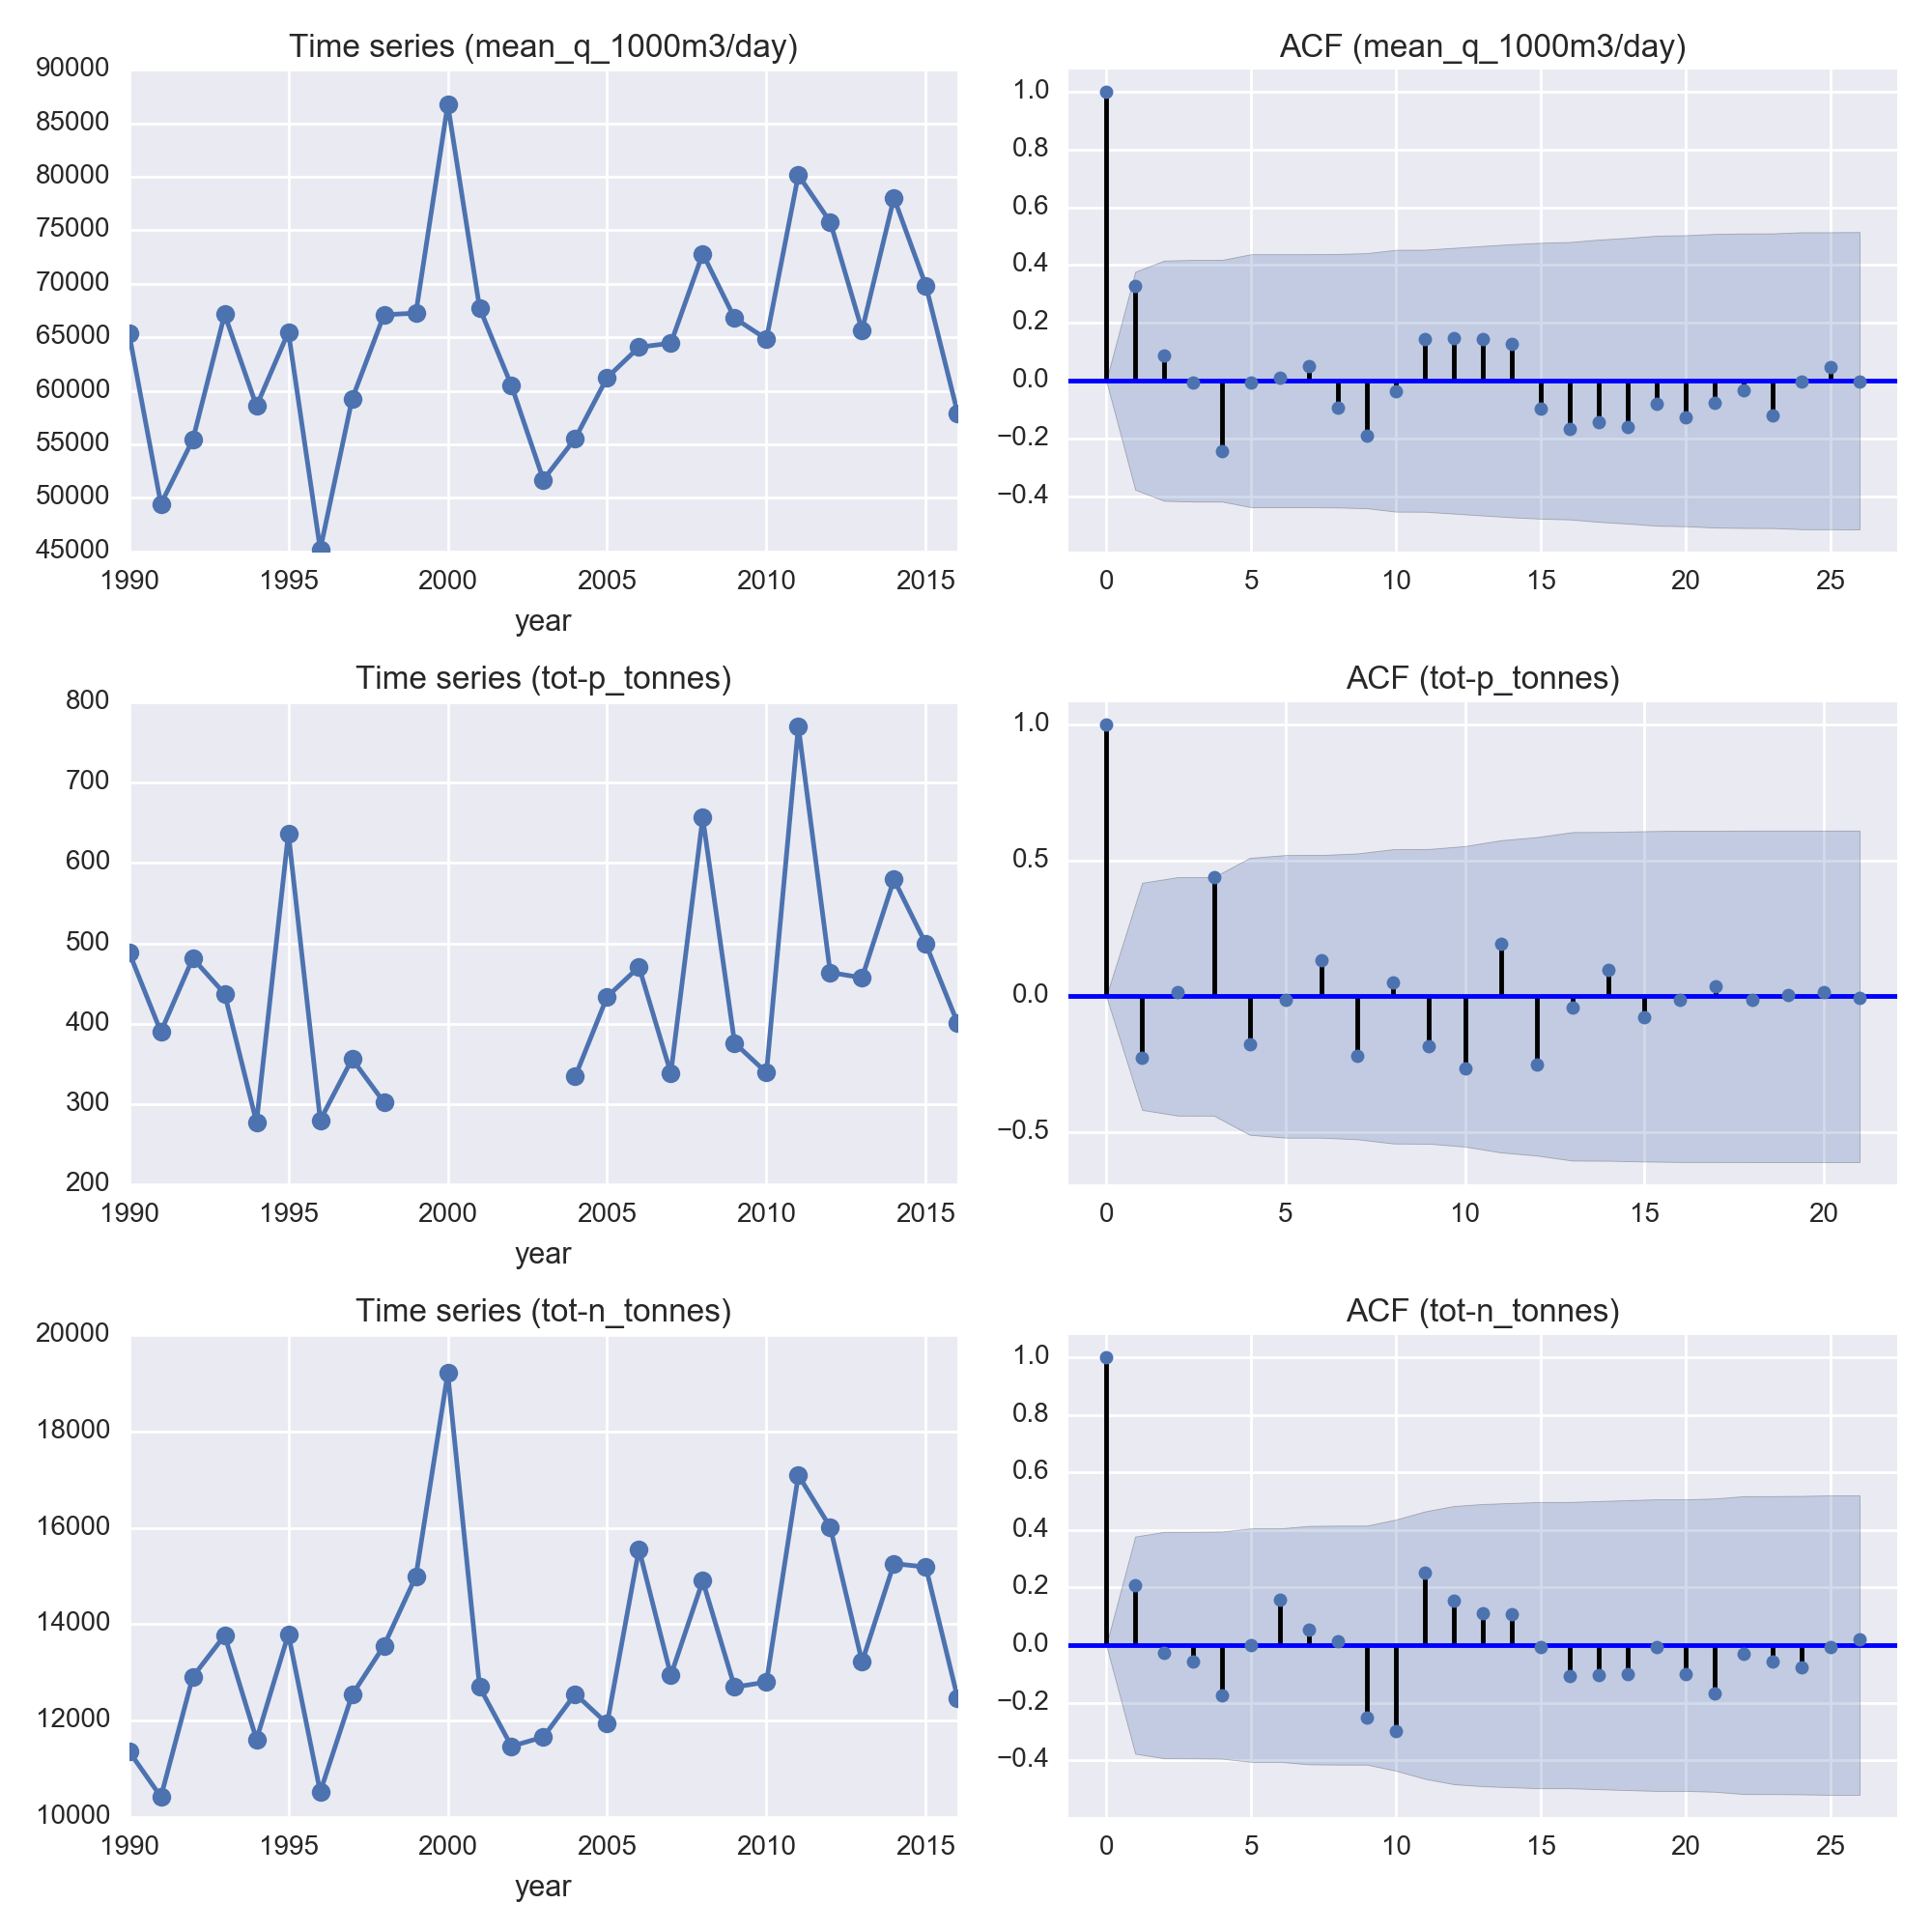

In [15]:
# Show Glomma
png_path = os.path.join(out_fold, '29617.png')
Image(png_path)

## 3. Generate NOPE input files

To run NOPE we also need input files for each year based on the data in RESA2. Unfortunately, not all the data is in the database, so some additional work is required initially to get everything organised.

### 3.1. Add agricultural land use coefficients

The update to section 4 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/prepare_teotil_inputs.ipynb) describes creating a new table in RESA2 and adding the 2015 data for agricultural land use coefficients. However, to run the model, I need to add all the data back to 1990, and the data format has not remained consistent throughout this period. The code below reads the input files previously generated for TEOTIL, restructures them and adds them to the database. However, the code in [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/prepare_teotil_inputs.ipynb) should be used rather than the code here for adding data for future years. 

In [16]:
# TEOTIL folder
teo_fold = r'K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler'

# Period of interest
st_yr, end_yr = 1990, 2015

# Read area data
fys_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_Core_Input_Data\fysone_land_areas.csv')
fys_df = pd.read_csv(fys_path, sep=';')
fys_df['omrade'] = fys_df['omrade'].str.decode('windows-1252')

# Container for data
df_list = []

# Loop over years
for year in range(st_yr, end_yr+1):
    # Path to LU coeffs. 
    in_csv = os.path.join(teo_fold, str(year),
                          'Koeffisienter_Jordbruk.txt')
    df = pd.read_csv(in_csv, sep=';', comment='!')

    # Column naming changes through time
    try:
        df = df[['Fylke_sone', 'Naker', 'Npunkt', 'Ndyrket_nat', 
                 'Paker', 'Ppunkt', 'Pdyrket_nat']]
        
        df.columns = ['fylke_sone', 'n_diff_kg', 'n_point_kg', 'n_back_kg',
                      'p_diff_kg', 'p_point_kg', 'p_back_kg']
        
    except KeyError:
        try:
            df = df[['Fylke_sone', 'Naker', 'Neng_punkt', 'Ndyrket_nat', 
                     'Paker', 'Peng_punkt', 'Pdyrket_nat']]  

            df.columns = ['fylke_sone', 'n_diff_kg', 'n_point_kg', 'n_back_kg',
                          'p_diff_kg', 'p_point_kg', 'p_back_kg']
            
        except KeyError:
            df = df[['Fylke_sone', 'Naker', 'Ndyrket_nat', 
                     'Paker', 'Pdyrket_nat']]  

            df.columns = ['fylke_sone', 'n_diff_kg', 'n_back_kg',
                          'p_diff_kg', 'p_back_kg']

            # Add missing point cols
            df['n_point_kg'] = 0
            df['p_point_kg'] = 0

            # Reorder
            df = df[['fylke_sone', 'n_diff_kg', 'n_point_kg', 'n_back_kg',
                     'p_diff_kg', 'p_point_kg', 'p_back_kg']]
   
    # Join område
    df = pd.merge(fys_df, df, how='left', on='fylke_sone')

    # Add year
    df['year'] = year
    
    # If data for Oslo are missing, patch with ake2
    df.set_index(['omrade', 'year'], inplace=True)
    if pd.isnull(df.loc['osl1', year]).any():
        df.loc['osl1', year] = df.loc['ake2', year]
    df.reset_index(inplace=True)
    
    # Convert kg/km2 to kg
    # 1. Point inputs
    for col in ['n_point_kg', 'p_point_kg']:
        df[col] = df[col] * df['a_fy_eng_km2']
        
    # 2. Background inputs
    for col in ['n_back_kg', 'p_back_kg']:
        df[col] = df[col] * df['a_fy_agri_km2']
    
    # 3. Diffuse inputs. NB the TEOTIL files assume diff = diff + back,
    # which is unnecessarily confusing. Convert back here to recreate original
    # Bioforsk data
    df['n_diff_kg'] = (df['n_diff_kg'] * df['a_fy_agri_km2']) - df['n_back_kg']
    df['p_diff_kg'] = (df['p_diff_kg'] * df['a_fy_agri_km2']) - df['p_back_kg']  

    # Tidy
    df = df[['omrade', 'year', 'n_diff_kg', 'n_point_kg', 
             'n_back_kg', 'p_diff_kg', 'p_point_kg', 'p_back_kg']]
    
    # Add to output
    df_list.append(df)
    
# Combine
df = pd.concat(df_list, axis=0)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
#from sqlalchemy import types
#
## Write to RESA
#df.to_sql(name='rid_agri_inputs', con=engine, 
#          schema='resa2', index=False, if_exists='append',
#          dtype={'omrade': types.VARCHAR(df['omrade'].str.len().max())})

### 3.2. Generate NOPE input files

In [18]:
# Period of interest
st_yr, end_yr = 1990, 2016

# Parameters of interest
par_list = ['Tot-N', 'Tot-P']

# Folder containing NOPE data
nope_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\NOPE_Core_Input_Data')

# Ouput folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_Annual_Inputs')

# Loop over years
for year in range(st_yr, end_yr+1):
    # Build path
    out_csv = os.path.join(out_fold, 'nope_input_data_%s.csv' % year)    

    # Make input file
    df = nope.make_rid_input_file(year, engine, nope_fold, out_csv,
                                  par_list=par_list)

No spredt data for 1990.
No renseanlegg data for 1990.
No spredt data for 1991.
No aquaculture data for 1991.
No renseanlegg data for 1991.
No spredt data for 1992.
No renseanlegg data for 1992.
No spredt data for 2016.
No aquaculture data for 2016.
No renseanlegg data for 2016.
No industry data for 2016.
No agricultural land use coefficients for 2016.


C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pandas\core\frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## 4. Compare total loads over time

The data has clearly changed quite a lot over the years. The code below reads the NOPE input files and plots total point and diffuse inputs for the whole of Norway for N and P. 

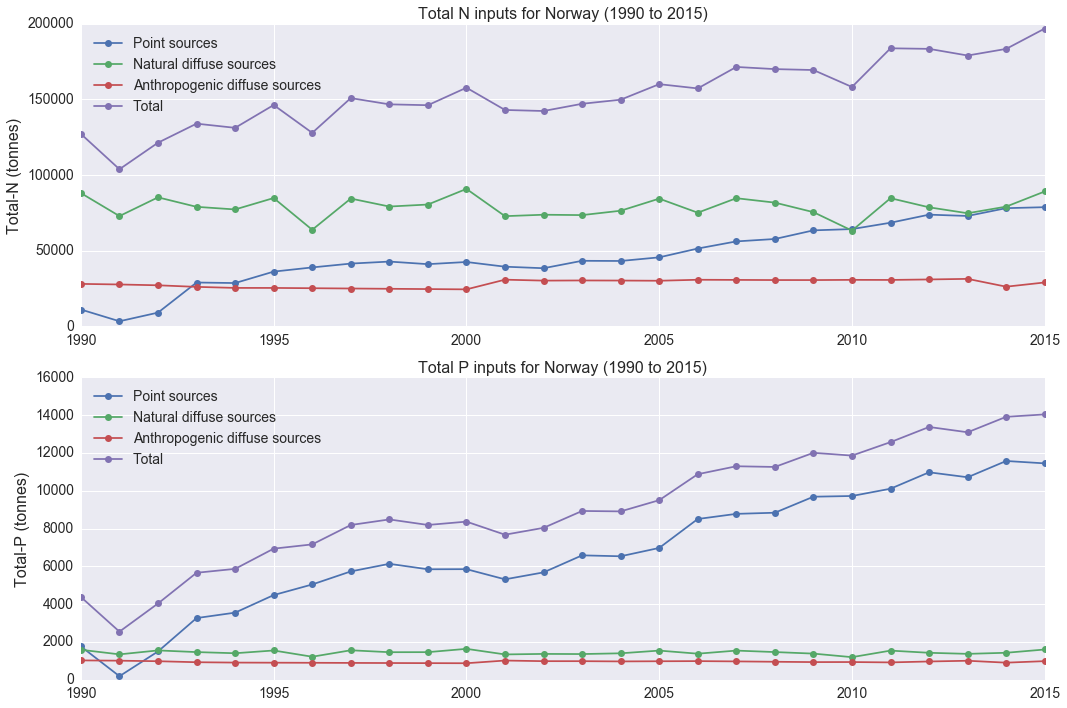

In [19]:
# Ouput folder
data_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\NOPE_Annual_Inputs')

# Container for data
df_list = []

# Cols of interest
cols = ['all_point_tot-n_tonnes', 'all_point_tot-p_tonnes', 'nat_diff_tot-n_tonnes',
        'nat_diff_tot-p_tonnes', 'anth_diff_tot-n_tonnes', 'anth_diff_tot-p_tonnes',
        'all_sources_tot-n_tonnes', 'all_sources_tot-p_tonnes']

# Loop over years
for year in range(1990, 2016):
    # Read data
    in_csv = os.path.join(data_fold, 'nope_input_data_%s.csv' % year)
    df = pd.read_csv(in_csv, usecols=cols)
    
    # Sum
    df = df.sum()
    
    # Add year
    df['year'] = year
    
    # Add to output
    df_list.append(df)

# Combine
df = pd.concat(df_list, axis=1)

# Tidy
df = df.T
df.index = df['year']
del df['year']

# Split N and P
n_df = df[[i for i in df.columns if i.split('_')[2]=='tot-n']]
n_df.columns = ['Point sources', 'Natural diffuse sources', 
                'Anthropogenic diffuse sources', 'Total']

p_df = df[[i for i in df.columns if i.split('_')[2]=='tot-p']]
p_df.columns = ['Point sources', 'Natural diffuse sources', 
                'Anthropogenic diffuse sources', 'Total']

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
n_df.plot(ax=axes[0], marker = 'o', fontsize=14)
p_df.plot(ax=axes[1], marker = 'o', fontsize=14)

axes[0].set_title('Total N inputs for Norway (1990 to 2015)', fontsize=16)
axes[1].set_title('Total P inputs for Norway (1990 to 2015)', fontsize=16)
axes[0].set_ylabel('Total-N (tonnes)', fontsize=16)
axes[1].set_ylabel('Total-P (tonnes)', fontsize=16)
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].legend(fontsize=14, loc='upper left')
axes[1].legend(fontsize=14, loc='upper left')

plt.tight_layout()

# Save
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_RID_Calibration_Data\norway_total_n_p_inputs_1990-2015.png')
plt.savefig(out_png, dpi=300)

plt.show()

This plot shows a very clear increase in point-source N and P inputs over time. I initially assumed this must be due to reporting bias (which would have implications for model calibration), but it is apparently due to a very substantial expansion of the aquaculture industry in Norway over the past few decades. This increase in nutrient inputs is not obvious in the observed data because most of the fish farms are located downstream of the RID monitoring stations. Both Øyvind and John Rune believe this increase to be genuine: see the e-mail from Øyvind received 31/08/2017 at 11.12 and the annual TEOTIL report for 2015.

With this in mind, it seems reasonable to begin calibrating the new model by **assuming spatially and temporally static parameter values**.